# Sensitive Set Transport Invariant Ranking (SenSTIR) demo

The idea of this notebook is to replicate the synthetic experiment shown in figure 1 of [Individually Fair Rankings](https://openreview.net/pdf?id=71zCSP_HuBN).

In [1]:
# !pip install matplotlib seaborn inFairness

In [2]:
import numpy as np

import torch
import torch.nn.functional as F

from torch import nn
from torch.utils.data.sampler import RandomSampler, BatchSampler
from torch.utils.data import IterableDataset

from inFairness.fairalgo import SenSTIR
from inFairness.distances import LogisticRegSensitiveSubspace, SquaredEuclideanDistance

from trainer import Trainer

from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable

import seaborn as sns
import numpy as np

/Users/mayank/opt/anaconda3/envs/infairness/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Synthetic data generation

In [3]:
def generate_synthetic_LTR_data(majority_proportion = .8, num_queries = 100, num_docs_per_query = 10, seed=0):
    num_items = num_queries*num_docs_per_query
    X = np.random.uniform(0,3, size = (num_items,2)).astype(np.float32)
    relevance = X[:,0] + X[:,1]
    
    relevance = np.clip(relevance, 0.0,5.0)
    majority_status = np.random.choice([True, False], size=num_items, p=[majority_proportion, 1-majority_proportion])
    X[~majority_status, 1] = 0
    return [{"Q":X[i], "relevances":relevance[i], "majority_status":majority_status[i]} for i in range(num_items)]

In [4]:
class QueryIterableDataset(IterableDataset):
    '''
    iterable dataset that takes a set of items and indifintely samples sets of such items (queries) per iteration
    '''
    def __init__(self, items_dataset, shuffle, query_size):
        self.dataset = items_dataset
        self.query_size = query_size
        self.shuffle = shuffle

    def __iter__(self):
        while True:
            idx = self._infinite_indices()
            query = [self.dataset[i] for i in next(idx)]
            query = torch.utils.data.default_collate(query)
            yield query
    
    def _infinite_indices(self):
        worker_info = torch.utils.data.get_worker_info()
        seed = 0 if worker_info is None else worker_info.id
        g = torch.Generator()
        g.manual_seed(seed)
        while True:
            if self.shuffle:
                idx = (torch.randperm(len(self.dataset))[:self.query_size]).tolist()
                yield idx

In [5]:
num_docs_per_query = 10
num_queries = 100
dataset_train = generate_synthetic_LTR_data(num_queries = num_queries, num_docs_per_query = num_docs_per_query)
dataloader = torch.utils.data.DataLoader(QueryIterableDataset(dataset_train, True, num_docs_per_query), batch_size=2)
#the data loader gets a batch of queries with relevance (batch x num_items_per_query) and features (batch x num_items_per_query x num_features)
next(iter(dataloader))

{'Q': tensor([[[1.1956, 1.4177],
          [1.6978, 0.1058],
          [2.3461, 2.7422],
          [1.6898, 1.1712],
          [1.1176, 1.0713],
          [0.5990, 2.8460],
          [2.0792, 2.9717],
          [2.6675, 2.5499],
          [1.1402, 0.0000],
          [2.5987, 1.4129]],
 
         [[2.8576, 1.4420],
          [0.4740, 0.7116],
          [1.6535, 2.0778],
          [0.1155, 1.9274],
          [2.4162, 0.6137],
          [1.6090, 2.0133],
          [2.8381, 2.2575],
          [1.5100, 0.0000],
          [2.6505, 1.4386],
          [0.2463, 1.2913]]]),
 'relevances': tensor([[2.6133, 1.8035, 5.0000, 2.8610, 2.1889, 3.4450, 5.0000, 5.0000, 1.8890,
          4.0116],
         [4.2997, 1.1856, 3.7313, 2.0429, 3.0298, 3.6223, 5.0000, 3.2417, 4.0891,
          1.5376]]),
 'majority_status': tensor([[ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
         [ True,  True,  True,  True,  True,  True,  True, False,  True,  True]])}

## Model and input/output distances

We also need a model we would like to train and to define distances in the input and output spaces.

In [6]:
class MultilayerPerceptron(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
all_data = torch.utils.data.default_collate(dataset_train)
x = all_data['Q']
majority_status = all_data['majority_status'].reshape(-1, 1)

distance_x = LogisticRegSensitiveSubspace()
distance_x.fit(data_X=x, data_SensitiveAttrs=majority_status)

# It's worth nothing that in the output space we are measuring distances between sets of scores 
# (each score corresponding to each document in a query). Therefore the dimensionality of the SquaredEuclideanDistance above.
distance_y = SquaredEuclideanDistance()
distance_y.fit(num_dims=num_docs_per_query)

## SenSTIR

High rho to enforce fairness.

In [8]:
fairalgo1 = SenSTIR(
    network=MultilayerPerceptron(),
    distance_x=distance_x,
    distance_y=distance_y,
    rho=0.01,
    eps=0.025,
    auditor_nsteps=20,
    auditor_lr=0.1,
    monte_carlo_samples_ndcg=20,
)
fairalgo1.train()

SenSTIR(
  (network): MultilayerPerceptron(
    (fc1): Linear(in_features=2, out_features=10, bias=True)
    (fc2): Linear(in_features=10, out_features=10, bias=True)
    (fc3): Linear(in_features=10, out_features=1, bias=True)
  )
  (distance_x): LogisticRegSensitiveSubspace()
  (distance_y): SquaredEuclideanDistance()
  (distance_q): WassersteinDistance()
)

## Baseline

Set rho to 0 to train the network normally.

In [9]:
baseline = SenSTIR(
    network=MultilayerPerceptron(),
    distance_x=distance_x,
    distance_y=distance_y,
    rho=0.0,
    eps=1.0,
    auditor_nsteps=50,
    auditor_lr=0.05,
    monte_carlo_samples_ndcg=20,
)
baseline.train()

SenSTIR(
  (network): MultilayerPerceptron(
    (fc1): Linear(in_features=2, out_features=10, bias=True)
    (fc2): Linear(in_features=10, out_features=10, bias=True)
    (fc3): Linear(in_features=10, out_features=1, bias=True)
  )
  (distance_x): LogisticRegSensitiveSubspace()
  (distance_y): SquaredEuclideanDistance()
  (distance_q): WassersteinDistance()
)

# Training Loop

In [10]:
%%time

trainer = Trainer(
    dataloader=dataloader,
    model=baseline,
    optimizer=torch.optim.Adam(baseline.parameters(),lr=0.005),
    max_iterations = 1000,
    print_loss_period= 50
)

trainer.train()

loss 0 tensor(11.4108, grad_fn=<MeanBackward0>)
loss 50 tensor(11.2143, grad_fn=<MeanBackward0>)
loss 100 tensor(11.6110, grad_fn=<MeanBackward0>)
loss 150 tensor(9.5448, grad_fn=<MeanBackward0>)
loss 200 tensor(10.1120, grad_fn=<MeanBackward0>)
loss 250 tensor(8.2067, grad_fn=<MeanBackward0>)
loss 300 tensor(7.6805, grad_fn=<MeanBackward0>)
loss 350 tensor(7.2427, grad_fn=<MeanBackward0>)
loss 400 tensor(6.9083, grad_fn=<MeanBackward0>)
loss 450 tensor(6.4046, grad_fn=<MeanBackward0>)
loss 500 tensor(6.0769, grad_fn=<MeanBackward0>)
loss 550 tensor(6.5780, grad_fn=<MeanBackward0>)
loss 600 tensor(5.0032, grad_fn=<MeanBackward0>)
loss 650 tensor(5.6520, grad_fn=<MeanBackward0>)
loss 700 tensor(5.5107, grad_fn=<MeanBackward0>)
loss 750 tensor(4.5727, grad_fn=<MeanBackward0>)
loss 800 tensor(4.8618, grad_fn=<MeanBackward0>)
loss 850 tensor(5.8006, grad_fn=<MeanBackward0>)
loss 900 tensor(4.3190, grad_fn=<MeanBackward0>)
loss 950 tensor(4.2139, grad_fn=<MeanBackward0>)
CPU times: user 1.4

In [11]:
%%time
trainer = Trainer(
    dataloader=dataloader,
    model=fairalgo1,
    optimizer=torch.optim.Adam(fairalgo1.parameters(),lr=0.005),
    max_iterations = 1000,
    print_loss_period= 50
)

trainer.train()

loss 0 tensor(11.7160, grad_fn=<MeanBackward0>)
loss 50 tensor(10.7771, grad_fn=<MeanBackward0>)
loss 100 tensor(11.2935, grad_fn=<MeanBackward0>)
loss 150 tensor(11.7498, grad_fn=<MeanBackward0>)
loss 200 tensor(11.3476, grad_fn=<MeanBackward0>)
loss 250 tensor(11.4476, grad_fn=<MeanBackward0>)
loss 300 tensor(12.0671, grad_fn=<MeanBackward0>)
loss 350 tensor(11.5299, grad_fn=<MeanBackward0>)
loss 400 tensor(11.9647, grad_fn=<MeanBackward0>)
loss 450 tensor(11.5349, grad_fn=<MeanBackward0>)
loss 500 tensor(11.6122, grad_fn=<MeanBackward0>)
loss 550 tensor(11.3988, grad_fn=<MeanBackward0>)
loss 600 tensor(11.7973, grad_fn=<MeanBackward0>)
loss 650 tensor(12.1100, grad_fn=<MeanBackward0>)
loss 700 tensor(11.7464, grad_fn=<MeanBackward0>)
loss 750 tensor(11.7279, grad_fn=<MeanBackward0>)
loss 800 tensor(11.3490, grad_fn=<MeanBackward0>)
loss 850 tensor(12.0832, grad_fn=<MeanBackward0>)
loss 900 tensor(12.1130, grad_fn=<MeanBackward0>)
loss 950 tensor(12.1327, grad_fn=<MeanBackward0>)
CPU

# Visualize Results

/var/folders/89/rg4sqb0n12jgc_lnk_932kr40000gn/T/ipykernel_8829/3326289861.py:39: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm)


<Figure size 600x1000 with 0 Axes>

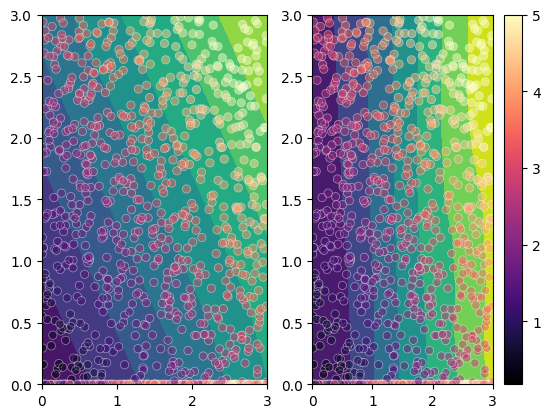

In [12]:
fairmodel = fairalgo1.network.eval()
baselinemodel = baseline.network.eval()

range_x = np.linspace(0,3,num=100).astype(np.float32)
range_y = np.linspace(0,3, num= 100).astype(np.float32)

def get_predicted_scores(model):
    xx, yy = np.meshgrid(range_x, range_y, sparse=False)
    y_pred = []

    for i in range(100):
        x = xx[i].reshape(-1, 1)
        y = yy[i].reshape(-1, 1)
        x_test = np.hstack([x, y])
        y_pred.append(model(torch.Tensor(x_test)).detach().numpy()[:, 0])
    
    return y_pred
        
def plot_contours_and_relevances(scores_pred, ax):
    scores_pred = np.array(scores_pred)
    ax.contourf(range_x, range_y, scores_pred)
    data_x = np.array(all_data['Q'])
    points = sns.scatterplot(x=data_x[:,0], y=data_x[:,1], c=all_data['relevances'], 
                             cmap='magma', ax=ax, alpha=0.5)

fig = plt.figure(figsize = (6,10))
fig, (ax1,ax2) = plt.subplots(1,2)
scores = get_predicted_scores(baselinemodel)
plot_contours_and_relevances(scores,ax1)
scores = get_predicted_scores(fairmodel)
plot_contours_and_relevances(scores,ax2)


# color bar denoting relevance
cmap = plt.get_cmap("magma")
norm = plt.Normalize(all_data['relevances'].min(),all_data['relevances'].max())
sm =  ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm)

The fair model is plotted on the right. As we can see from the contours of the fair model, the resulting network is not sensitive to the vertical dimmension, while the baseline is.